# GalSim Chromatic Objects for DEDALE
---
> Author: **Samuel Farrens [<samuel.farrens@gmail.com>]**  
> Year: **2018**

This notebook is used to generate multi-colour galaxy images with a either a Sersic, Exponential or single pixel profile using LSST and Euclid filters. SEDs are drawn from simulated spectra.

## Set-Up
---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import galsim
from astropy import units as u
from os import environ
import pandas as pd

In the next cell you should set the path to your local GalSim installation in order to find the LSST filters.

You should also set the desired number of galaxy images and the postage stamp size for each image.

In [2]:
# Set path to GalSim
galsim_path = galsim.meta_data.share_dir
dedale_path = environ['HOME'] + '/Documents/Projects/DEDALE/spec_phot/'

# Set total number of galaxy images to generate
sample_size = 50

# Postage stamp size
postage = [41, 41]

# Update FFT size
big_fft_params = galsim.GSParams(maximum_fft_size=10240)

## Survey Properties
---

The cell below sets properties for the LSST and Euclid surveys.

In [3]:
# Filter Names
lsst_filters = 'ugrizy'
euclid_filters = 'yJH'

filter_names = ['lsst_' + f for f in lsst_filters] + ['euclid_' + f for f in euclid_filters]

# Pixel Scale
lsst_pixel_size = 0.2
# euclid_pixel_size = 0.3 # True Euclid pixel scale
euclid_pixel_size = lsst_pixel_size

pixel_sizes = [lsst_pixel_size for f in lsst_filters] + [euclid_pixel_size for f in euclid_filters]

# PSF FWHM
# lsst_psf_fwhm = 0.7 # Not currently used
euclid_psf_fwhm = 0.3

## Labels
---

The following cell extracts the object IDs, SED types and redshifts from the file `2017-12-06_LSST_photometry.csv`.

In [4]:
object_ids, object_seds, object_z = np.genfromtxt(dedale_path + '2017-12-06_LSST_photometry.csv', dtype=str,
                                                   delimiter=',', skip_header=1, unpack=True)[:3, :sample_size]

labels = pd.DataFrame(data={'ID': object_ids, 'SED_ID': object_seds, 'z': object_z}, dtype='object')

del object_ids, object_seds, object_z

## Survey Bandpasses
---

The following cell generates GalSim Bandpass objects using LSST and Euclid filters.

In [5]:
# Set path to LSST filters files
lsst_path = galsim_path + '/bandpasses/'
euclid_path = dedale_path + 'euclid_bandpasses/'

# Create dictionary of galsim Bandpass objects
filters = {'lsst_' + filt: galsim.Bandpass(lsst_path + 'LSST_' + filt + '.dat', 
           wave_type='nm').thin(rel_err=1e-4) for filt in lsst_filters}
filters.update({'euclid_' + filt: galsim.Bandpass(euclid_path + filt + '_NISP.Euclid.pb', 
                wave_type='nm').thin(rel_err=1e-4) for filt in euclid_filters})

## Object SEDs
---

The following cell generates GalSim SED objects using simulated spectra.

In [6]:
def get_sed(file_name):
    
     return galsim.SED(file_name, wave_type=u.AA, flux_type=u.erg/(u.s*u.cm**2*u.AA))

# Set path to SED files
sed_path = dedale_path + 'sed_files/'

# # Create dictionary of galsim SED objects
seds = np.array([get_sed(sed_path + 'obj_{}.sed'.format(obj_id)) for obj_id in labels.ID])

## Image Sizes
---

The following cell uses a range of half-light radius values taken from Great3 data. Galaxy images will be assigned a random flux that follows the distribution in the file `hlr_dist.npy`.

In [7]:
# Read in half light radius (HLR) distribution
hlr_dist = np.load('hlr_dist.npy')

# Get the probability density of HLR values
hlr_hist, hlr_bins = np.histogram(hlr_dist, bins=50, density=True)

# Normalise HLR hist values
hlr_hist /= hlr_hist.sum()

# Adjust bin edges to bin centres
hlr_bins = (hlr_bins[:-1] + hlr_bins[1:]) / 2.0

# Define random HLR values from PDF
random_hlr = (np.random.choice(hlr_bins, size=sample_size, p=hlr_hist) + 
              np.random.ranf(sample_size) * (hlr_bins[1] - hlr_bins[0]))

del hlr_dist, hlr_hist, hlr_bins

## Image Ellipticities
---

The following cell sets random ellipticity parameters for the images.

In [8]:
# Random rotation
object_beta = np.array([galsim.Angle(np.random.ranf() * 180.0, galsim.degrees) for i in range(sample_size)])
# Random axis ratio
object_q = np.array([np.random.ranf() for i in range(sample_size)])
# Ellipticity components
labels['e1'] = np.array([galsim.Shear(q=q, beta=beta).e1 for q, beta in zip(object_q, object_beta)])
labels['e2'] = np.array([galsim.Shear(q=q, beta=beta).e2 for q, beta in zip(object_q, object_beta)])

## Galaxy Type
---

The following cell sets random galaxy types

In [9]:
types = ('sersic', 'exponential', 'pixel')
labels['Type'] = np.array([types[np.random.randint(0, 3)] for i in range(sample_size)])

## Generate Images
---

### Extraction of Image Matrices

The following function simply draws the desired chromatic object in each of the survey filters and saves the matrices to a cube.

In [10]:
# Define function to retrieve galaxy images
def get_images(chromatic_object):
    
    images = []

    for filter_name, pixel_size in zip(filter_names, pixel_sizes):

        # Create a galsim ImageF object with the size of the predefined postage stamp
        image = galsim.ImageF(*postage)
                
        # Draw chromatic object images in given filters
        chromatic_object.drawImage(filters[filter_name], image=image, scale=pixel_size)

        # Extract image matrix
        images.append(image._image.array)
    
    return images

### Image Generation

The following cell generates the multiband galaxy images and assignes the random half-light radius, angle and shear values defined above.

In [11]:
def make_cube(obj_num):
    
    obj = labels.loc[obj_num]
    sed = seds[obj_num]
    hlr = random_hlr[obj_num]
    beta = object_beta[obj_num]
    q = object_q[obj_num]
                    
    # Generate a monochromatic object with given half light radius
    if obj.Type == 'sersic':
        mono_gal = galsim.Sersic(n=4, half_light_radius=hlr).shear(q=q, beta=beta)
    elif obj.Type == 'exponential':
        mono_gal = galsim.Exponential(half_light_radius=hlr).shear(q=q, beta=beta)
    elif obj.Type == 'pixel':
        mono_gal = galsim.Pixel(1., 1.)
                        
    # Create a standard chromatic object instance
    chromo_gal = mono_gal * sed.atRedshift(0.0)
    
    # Convolve with PSF
#     chromo_gal = galsim.Convolve([chromo_gal, galsim.Moffat(fwhm=psf_size, beta=2.5)])
    chromo_gal = galsim.Convolve([chromo_gal, galsim.Gaussian(fwhm=euclid_psf_fwhm)], gsparams=big_fft_params)
            
    return get_images(chromo_gal)


In [12]:
images = np.array([make_cube(i) for i in range(sample_size)])

## Sample Outputs
---

### Sample Labels

In [13]:
# Show first 10 labels
labels.loc[:10]

,ID,SED_ID,z,e1,e2,Type
0,256183,223,0.306,0.184411,0.135047,pixel
1,256184,8788,0.478,-0.571527,-0.773683,sersic
2,256326,7377,0.2196,0.080597,0.477548,exponential
3,256424,8233,0.3334,-0.150874,0.714319,exponential
4,256455,1511,1.0885,0.114744,-0.060535,sersic
5,256908,4930,0.6344,-0.263011,-0.026365,exponential
6,256909,263,0.2102,0.016004,0.440093,sersic
7,256957,3922,1.5873,-0.025058,-0.340294,sersic
8,257019,2314,0.2626,-0.304628,0.395187,sersic
9,257058,6010,1.3223,-0.079714,-0.745784,sersic


In [14]:
# Plot the images for a specified object
def show_images(image):

    plt.figure(figsize=(14, 9))

    for i in range(len(filters)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i], interpolation='none', cmap='magma', vmin=0, vmax=np.max(image))
        plt.axis('off')
        plt.title(filter_names[i], fontsize=20)

    plt.show()

### Sersic Images

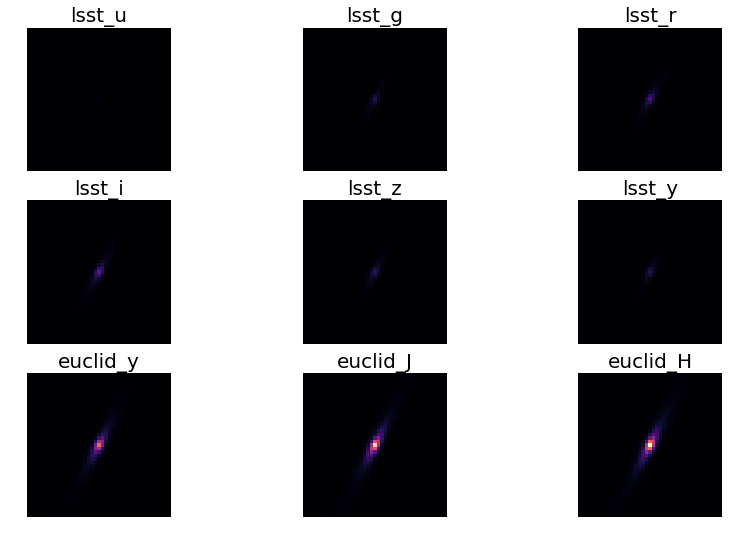

In [15]:
show_images(images[labels[labels.Type == "sersic"].index[0]])

### Exponential Images

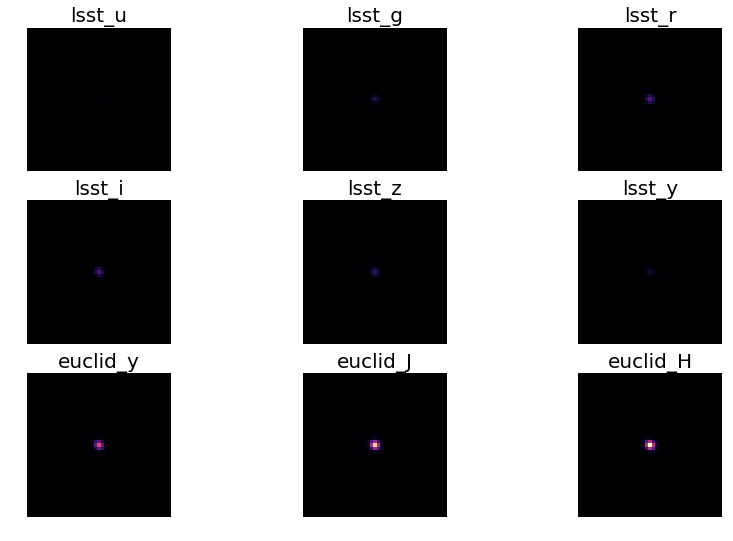

In [16]:
show_images(images[labels[labels.Type == "exponential"].index[0]])

### Pixel Images

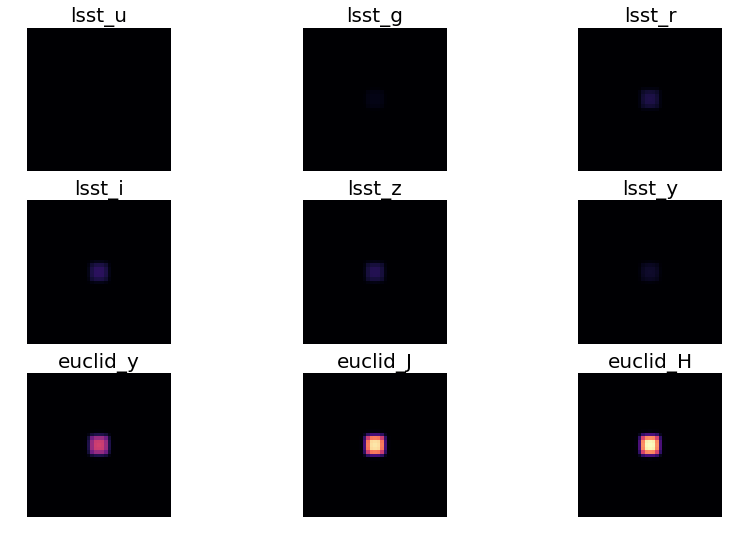

In [17]:
show_images(images[labels[labels.Type == "pixel"].index[0]])

## Output
---

Finally this cell saves the galaxy images to a Numpy binary file called `chromatic_images.npy`.

In [18]:
# Save imgaes to Numpy binary
np.save('chromatic_images.npy', images)

In [19]:
# Save labels to pickle
labels.to_pickle('image_labels.pkl')